In [1]:
from tqdm import tqdm_notebook

import numpy as np
np.random.seed(1)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

try : 
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
except : 
    import nltk
    nltk.download('vader_lexicon')  
    vader = SentimentIntensityAnalyzer()
    
import warnings
warnings.simplefilter("ignore")

/home/hfcp/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
model = pd.read_pickle('pretrained-w2v.gensim')

In [5]:
lemma_dict = model.key_to_index
vectors = model.vectors

<AxesSubplot:title={'center':'l2-norm'}>

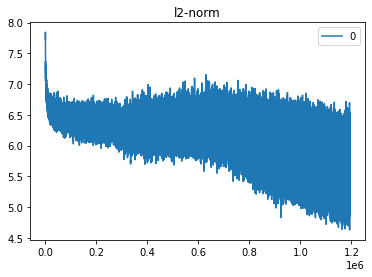

In [6]:
norm_dist = np.linalg.norm(vectors, axis=1)
pd.DataFrame(norm_dist).rolling(100).mean().plot(title='l2-norm')

___

In [7]:
def get_word_candidates(init, sim_const) :
    cand = []
    for w in model.similar_by_word(init) : 
        if w[1] > sim_const : 
            cand.append(w[0])
    return cand

iteratively search sentiment vocab

In [8]:
pos_container = []
cand = get_word_candidates('great', sim_const=0.75) # positiv word init
pos_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(pos_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        pos_container += value

neg_container = []
cand = get_word_candidates('bad', sim_const=0.75) # negative word init
neg_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(neg_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        neg_container += value
        
sentiment_vocab = list(set(pos_container).union(set(neg_container)))
print("===" * 10)
print("The # of positive words picked :", len(set(pos_container)))
print("The # of negative words picked :", len(set(neg_container)))
print("The # of sentimental words picked :", len(sentiment_vocab))
print("The # of intersection between pos/neg :", len(set(pos_container).intersection(set(neg_container))))
print("===" * 10)

The # of positive words picked : 282
The # of negative words picked : 384
The # of sentimental words picked : 441
The # of intersection between pos/neg : 225


In [9]:
sentiment_idx = [v for k,v in lemma_dict.items() if k in sentiment_vocab]
notsentiment_idx = [v for k,v in lemma_dict.items() if k not in sentiment_vocab]
positive_idx = [v for k,v in lemma_dict.items() if k in set(pos_container)]
negative_idx = [v for k,v in lemma_dict.items() if k in set(neg_container)]

# to easy-compare and visualize, I sampled the same number for indexes from ~sentiment candidates
# since it gives stochasticity in research, we need to do sampling multiple times for more robust result 
notsentiment_idx = np.random.choice(notsentiment_idx, len(sentiment_idx), replace=False)

____

In [31]:
def proj_and_subtr(mat, vec) : 
    proj = np.dot(mat, vec)/np.dot(vec, vec)
    return mat - proj.reshape(-1,1)

<AxesSubplot:ylabel='Density'>

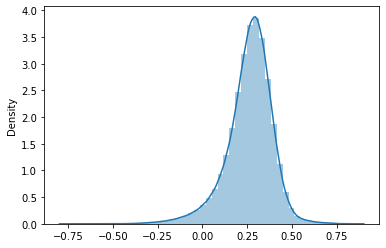

In [27]:
sim = cosine_similarity(vectors, np.mean(vectors, 0).reshape(1,-1)).reshape(-1)
sns.distplot(sim)

<AxesSubplot:ylabel='Density'>

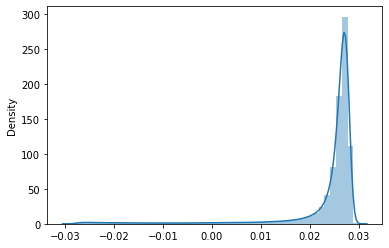

In [32]:
demean_vec = proj_and_subtr(vectors, np.mean(vectors, 0))
sim = cosine_similarity(demean_vec, np.mean(vectors, 0).reshape(1,-1)).reshape(-1)
sns.distplot(sim)

In [36]:
# iteratively calculate eigenvector/value since the data is too large to run at once
iters = 10
S_mem = []
Vt_mem = []

for _ in tqdm_notebook(range(iters)) : 
    rand_idx = np.random.choice(demean_vec.shape[0], 10000, replace=False)
    U, S, Vt = np.linalg.svd(demean_vec[rand_idx])
    S_mem.append(S)
    Vt_mem.append(Vt)

In [38]:
S = np.dstack(S_mem).mean(2)
Vt = np.dstack(Vt_mem).mean(2)

In [47]:
exp_cumsum = np.cumsum((S**2)/np.sum(S**2))[:30]
print(exp_cumsum)
# the first PC has about 87% variance explanatory power!

[0.8693422  0.8713302  0.8731197  0.87463427 0.8760074  0.87729126
 0.87852055 0.87971133 0.88085777 0.8819564  0.8830233  0.88405144
 0.8850519  0.88603395 0.8869986  0.8879486  0.88888144 0.8898009
 0.8907098  0.8916082  0.89249766 0.89337677 0.89424527 0.8951057
 0.8959583  0.89680344 0.8976404  0.8984702  0.89929634 0.9001149 ]


In [60]:
truncate_idx = np.where(exp_cumsum > 0.9)[0].item()
reduced_emb = np.dot(demean_vec, Vt[:truncate_idx].transpose(1,0))/S[:,:truncate_idx]

In [62]:
notsentiment_vector = reduced_emb[notsentiment_idx]
sentiment_vector = reduced_emb[sentiment_idx]

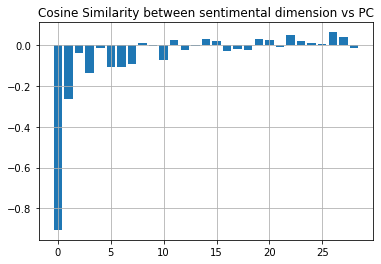

In [93]:
sim_arr = cosine_similarity(reduced_emb.transpose(1,0), vectors[:,152].reshape(1,-1)).reshape(-1)
plt.title("Cosine Similarity between sentimental dimension vs PC")
plt.bar(range(reduced_emb.shape[1]), sim_arr)
plt.grid()
plt.show()

____

In [64]:
def calc_ztest(dist1, dist2) : 
    mean1 = np.mean(dist1)
    mean2 = np.mean(dist2)
    std1 = np.std(dist1)
    std2 = np.std(dist2)
    return (mean1-mean2)/np.sqrt(std1**2+std2**2)

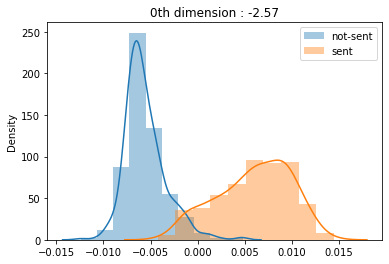

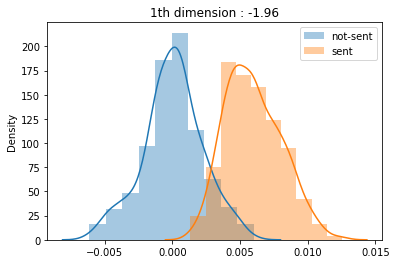

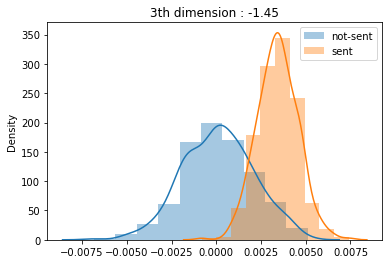

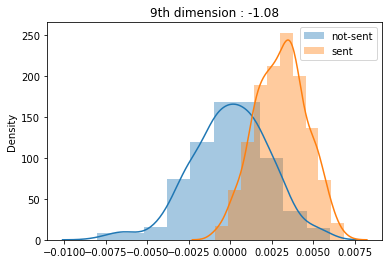

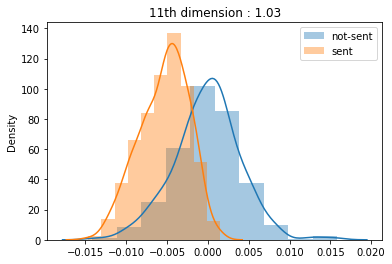

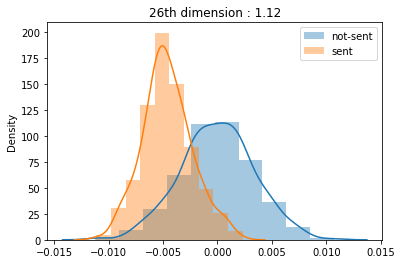

In [66]:
embed_dim = reduced_emb.shape[1]
score_mem = []

for idx in range(embed_dim) : 
    score = np.round(calc_ztest(notsentiment_vector[:,idx], sentiment_vector[:,idx]), 2)    
    if np.abs(score) >= 1 : 
        score_mem.append(idx)
        plt.title("{}th dimension : {}".format(idx, score))    
        _ = sns.distplot(notsentiment_vector[:,idx], bins=10, label='not-sent')
        _ = sns.distplot(sentiment_vector[:,idx], bins=10, label='sent')
        plt.legend()
        plt.show()

___

In [72]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((reduced_emb[:,0] > .005) & (reduced_emb[:,0] < 0.02)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0692


In [71]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((reduced_emb[:,0] < -.005) & (reduced_emb[:,0] > -0.015)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0011


___

In [74]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((reduced_emb[:,1] > .005) & (reduced_emb[:,1] < 0.02)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0804


In [73]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((reduced_emb[:,1] < -.0) & (reduced_emb[:,1] > -0.005)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0001


____

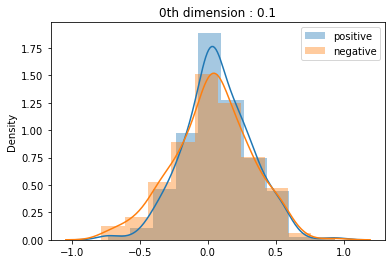

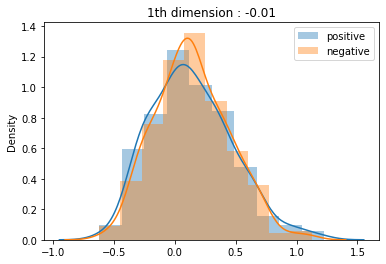

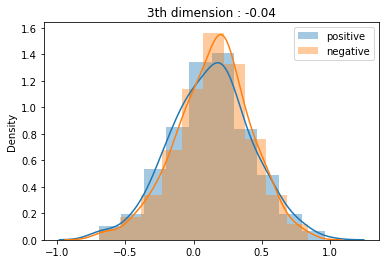

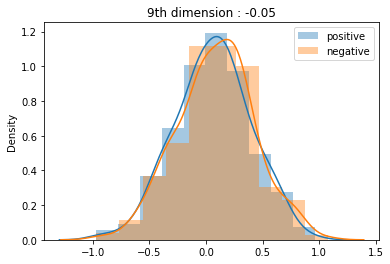

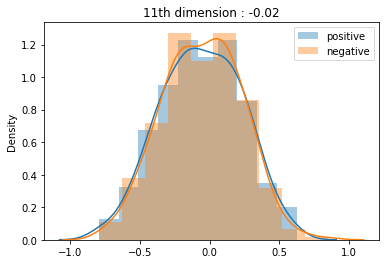

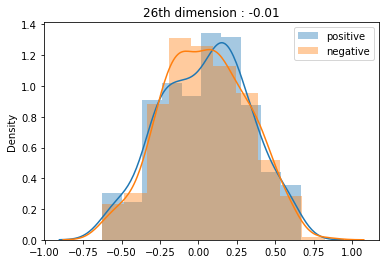

In [75]:
for idx in score_mem : 
    dist1 = vectors[positive_idx][:,idx]
    dist2 = vectors[negative_idx][:,idx]
    score = np.round(calc_ztest(dist1, dist2), 2)    
    
    plt.title("{}th dimension : {}".format(idx, score))
    _ = sns.distplot(dist1, bins=10, label='positive')
    _ = sns.distplot(dist2, bins=10, label='negative')
    plt.legend()
    plt.show()